# Model Project:
# Overlapping Generation Model, with population growth

In this project we simulate a version of the Overlapping Generations (OLG) model, extended with **population growth**.
    
In a first step we will solve part of the model analytically, to find the optimal level of savings in the simplified situation of Logarithmic utility and Cobb Douglass production function.
      
Mantaining this basic setting we will then attemp to find a numerical solution for the optimal saving rate; we will check the correctness of the results by plotting the dynamics of the level of capital in time and confronting it to the level we expect from theoretical derivations (the **steady-state level of capital**).
  
We will encounter some unexpected behaviour and give our explanation to it.

**Table of contents**<a id='toc0_'></a>    
- 0. [Setup](#toc0_) 
- 1. [Model description](#toc1_)    
  - 1.1. [Method of solution](#toc1_1_)    
- 2. [Analytical solution](#toc2_)    
- 3. [Numerical solution](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 0. <a id='toc0_'></a>[Setup](#toc0_)

In the following cell we import the necessary packages and fix some general settings:

In [1]:
# import the autoreload functionality
%load_ext autoreload
%autoreload 2

# import numpy
import numpy as np

# imports display tool
from IPython.display import display

# imports and setup graph tools
from OLG_growth_model import capital_accumulation_plot # ad-hoc capital accumulation graph plot
from OLG_growth_model import population_plot # ad-hoc capital population growth plot
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# imports the class for the model
from OLG_growth_model import OLGModelClass

# imports symbolic math tools
import sympy as sm


## 1. <a id='toc1_'></a>[Model description](#toc1_)

*In this chapter we report the mathematical description of model.*
*The main structure of the model has been recovered from the "Introduction to programmin and numerycal analysis" lecture notes.*
*The main changes made are highlighted in red.*

*In the whole descrpition capital letters are aggregate variables.*

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics:** <font color=red>  
A life consists of two periods, *young* and *old*. 
Young population at time $t$ is $L_t$, while old population is $L_{t-1}$. Population growth rate is n, so that:

$$
\begin{aligned}
L_t & = L_{t-1}(1+n) \\ 
\text{with}\ n &>-1
\end{aligned}
$$
</font>

**Households:** 
No unemployment is assumed in the young population so labour market clears, with $L_t$ equal to $N_t$, which represents the employed workers in the economy. Each individual supplies one unit of labour. 
At the aggregate level, young individuals earn a <font color=blue>after tax wage</font> $(1-\tau_w)w_{t}N_{t}$.<br>
Consumption as young and old are denoted by $C_{1t}$ and $C_{2t+1}$. 
The <font color=blue>after-tax return on saving</font> is $(1-\tau_{r})r_{t+1}$.<br>
The household decision problem can be represented as following:
    
$$
\begin{aligned}
U & =\max_{s_{t}\in[0,1]}\frac{C_{1t}^{1-\sigma}}{1-\sigma}+\beta\frac{C_{2t+1}^{1-\sigma}}{1-\sigma},\,\,\,\beta > -1, \sigma > 0\\
 & \text{s.t.}\\
 & S_{t}=s_{t}(1-\tau_{w})w_{t}N_{t}\\
 & C_{1t}=(1-s_{t})(1-\tau_{w})w_{t}N_{t}\\
 & C_{2t+1}=(1+(1-\tau_{r})r_{t+1})S_{t}
\end{aligned}
$$

In case of $\sigma=1$ we have logarithmic utility and the intertemporal utility function becomes:

$$
\begin{aligned}
U & = log{C_{1t}}+\beta(log{C_{2t+1}}),\,\,\,\beta > -1\\
\end{aligned}
$$

Where $r_{t}$ is the <font color=blue>interest rate on savings</font>, $S_{t}$ are the <font color=blue>total savings</font> and $s_{t}$ is the <font color=blue>saving rate</font>.
The problem is formulated in terms of the saving rate $s_t\in[0,1]$.

**Firms:** Firms rent capital $K_{t-1}$ at the <font color=blue>rental rate</font> $r_{t}^{K}$,
and hires labor $N_{t}$ at the <font color=blue>wage rate</font> $w_{t}$. Firms have access
to the CES production function:
$$
\begin{aligned}
Y_{t}=F(K_{t-1},L_{t})= \left( \gamma K_{t-1}^{-\theta}+(1-\gamma)L_{t}^{-\theta} \right)^{\frac{1}{-\theta}},\,\,\,\theta>-1,\gamma\in(0,1)
\end{aligned}
$$

We'll focus on the special case of Cobb-Douglas production function:

$$
\begin{aligned}
Y_{t}=F(K_{t-1},L_{t})=A_tK_{t-1}^{\alpha}L_{t}^{1-\alpha}
\end{aligned}
$$

    
<font color=blue>Profits</font> are
    
$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}L_{t}-r_{t}^{K}K_{t-1}
\end{aligned}
$$

**Government:** Choose <font color=blue>public consumption (expenditure)</font>, $G_{t}$, and <font color=blue>(income) tax rates</font> $\tau_w \in [0,1]$ and $\tau_r \in [0,1]$. <font color=blue>Total tax revenue</font> is
    
$$
\begin{aligned}
T_{t} &=\tau_r r_{t} (K_{t-1}+B_{t-1})+\tau_w w_{t}N_{t}   
\end{aligned}
$$

Where $B_{t-1}$ is the <font color=blue>value of bond outstanding</font>.
Government debt accumulates according to
    
$$
\begin{aligned}
B_{t} &=(1+r^b_{t})B_{t-1}-T_{t}+G_{t} 
\end{aligned}
$$

Where $r^b_{t}$ 
A *balanced budget* implies $G_{t}=T_{t}-r_{t}B_{t-1}$.

**Capital:** Depreciates with a rate of $\delta \in [0,1]$.

**At equilibrium:**

1. Households maximize utility
2. Firms maximize profits
3. No-arbitrage between bonds and capital

    $$
    r_{t}=r_{t}^{K}-\delta=r_{t}^{b}
    $$

4. Labor market clears: $L_{t}=N_{t}$
5. Goods market clears: $Y_{t}=C_{1t}+C_{2t}+G_{t}+I_{t}$
6. Asset market clears: $S_{t}=K_{t}+B_{t}$
7. Capital follows its law of motion: $K_{t}=(1-\delta)K_{t-1}+I_{t}$

Where $I_{t}$ is investment.

### 1.1. <a id='toc1_1_'></a>[Method of solution](#toc0_)

*In this sub-chapter we illustrate the further derivations to find the optimal value of the saving rate and a schetch of the algorithm that is going to be utilized to find the numerical solution:*

**Implication of profit maximization**  

The solution to the firm problem results in the following FOC's:

$$
\begin{aligned}
r_{t}^{k} & =F_{K}(K_{t-1},L_{t})=\alpha K_{t-1}^{-\theta-1}Y_{t}^{1+\theta}\\
w_{t} & =F_{E}(K_{t-1},L_{t})=(1-\alpha)L_{t}^{-\theta-1}Y_{t}^{1+\theta}
\end{aligned}
$$

**Implication of utility maximization**  

The solution to the household problem results in the following condition, called the Euler equation:

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta (1+(1-\tau_r)r_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

*To solve the model numerycally we proceed with two different algorithmic tools: a simulation and a solution finder:*  

- *The simulation permits the calculation of all the parameters values, beside $s_t$.*

- *The solution finder search for the optimal value of $s_t$ such that, given the known parameters at time $t$, utility is optimized at all periods of the household lifetime: it basically means optimizing the Euler equation.*

**Simulation algorithm:**  
At the beginning of period $t$, the economy can be summarized in the state variables $K_{t-1}$ and $B_{t-1}$.<br>

*Before* $s_t$ is known, we can calculate:

$$
\begin{aligned}
Y_{t} & =F(K_{t-1},L_t)\\
r_{t}^{k} & =F_{K}(K_{t-1},1)\\
w_{t} & =F_{L}(K_{t-1},1)\\
r_{t} & =r^k_{t}-\delta\\
r_{t}^{b} & =r_{t}\\
\tilde{r}_{t} & =(1-\tau_{r})r_{t}\\
C_{2t} & =(1+\tilde{r}_{t})(K_{t-1}+B_{t-1})\\
T_{t} & =\tau_{r}r_{t}(K_{t-1}+B_{t-1})+\tau_{w}w_{t}\\
B_{t} & =(1+r^b_{t})B_{t-1}+T_{t}-G_{t}\\
L_{t} & = L_{t-1}(1+n)\\
\end{aligned}
$$

*After* $s_t$ is known we can calculate:

$$
\begin{aligned}
C_{1t} & = (1-s_{t})(1-\tau_{w})w_{t}\\
I_{t} & =Y_{t}-C_{1t}-C_{2t}-G_{t}\\
K_{t} & =(1-\delta)K_{t-1} + I_t
\end{aligned}
$$

**Solution algorithm:** Simulate forward choosing $s_{t}$ so
that we always have:

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta(1+\tilde{r}_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

## 2. <a id='toc1_2_'></a>[Analytical solution](#toc0_)

*At first we attempt to solve part of the model analytically.* 

*We try to find the optimal saving rate, given logarithmic period utility function.*  

*For this purpose we import a function made ad-hoc to solve the household problem analitycally while showing each step of the derivation.*  
*The function provides also characterization to get the final value of the saving rate.*  
*The optimal value of $s_t$ is determined, given the value of $\beta$ which can be chosen when calling the solver function:*

In [2]:
from Analytical_solver import log_analytic # imports ad-hoc analytical solver for optimal saving rate

log_analytic() # call ad-hoc analytical solver with beta parameter value = 1/1.4 (default)

Objective function:


beta*log(C_{2t+1}) + log(c_{1t})



Budget constraints:


Eq(N_{t}*s_t*w_t*(1 - tau_w), S_t)

Eq(N_{t}*w_t*(1 - s_t)*(1 - tau_w), c_{1t})

Eq(S_t*(r_{t+1}*(1 - tau_r) + 1), C_{2t+1})



Substitution of St inside function for consumption of old agents:


Eq(N_{t}*s_t*w_t*(1 - tau_w)*(r_{t+1}*(1 - tau_r) + 1), C_{2t+1})



Substitution of old and young consumption inside objective function:


beta*log(N_{t}*s_t*w_t*(r_{t+1}*tau_r*tau_w - r_{t+1}*tau_r - r_{t+1}*tau_w + r_{t+1} - tau_w + 1)) + log(N_{t}*w_t*(s_t*tau_w - s_t - tau_w + 1))



FOC of objective modified function wrt st:


beta/s_t + (tau_w - 1)/(s_t*tau_w - s_t - tau_w + 1)



Value of st that solves FOC=0:


beta/(beta + 1)



Optimal value of st for beta = 0.7142857142857143:


0.41666666666666663

We'll in the next step, that the simulation of the model trough the algorithms will yield the same value of $s$, when the settings are the same (same values of $\beta,\sigma,\theta$).

## 3. <a id='toc1_4_'></a>[Numerical solution](#toc0_)

Here we apply the simulation and solution algorithms described above to find the optimal value of the saving rate. 

The algorithms presented is an extension of the "Introduction to programming", "OLG" lecture, and is stored in the py file "OLG_growth_model" in the project folder.

We simulate the model for 50 periods, while using some simplifying assumption:

- The period utility function is logarithmic (CRRA utility with $\sigma = 1$)

- The production function is of the Cobb Douglas type (CES production with $\theta = 0$)

To check the validity of the optimal savings selected by the algorithm we are going to confront the level of capital accumulated across a long period of time, with the steady state level of capital (which is the theoretical expected value of capital in the long run):  in this simplifiend special LOG/CD setting the capital level accumulated should converge to the expected steady state level, in the long run.

*The expected steady state level, when population is growing, can be defined as:*

$$ \lim_{t\rightarrow\infty} K_t = \left(\frac{1-\alpha}{(1+n)(1+1/\beta)}\right)^{\frac{1}{1-\alpha}} $$

In [3]:
from Analytical_solver import steady_state # imports ad-hoc analytical solver for steady state capital

steady_state() # call ad-hoc analytical solver with default values of beta, alpha and n

((1 - alpha)/((1 + 1/beta)*(n + 1)))**(1/(1 - alpha))

For alpha = 0.5;
beta = 0.7142857142857143;
n = 0.1;
Steady state value of capital, k_ss =


0.035870064279155185

We will:
1) create an instance of the model and setup the parameters as desired;  

2) check that the Euler equation is respected by calculating the difference between the left hand and right hand sides of the equaation at each period;  

3) plot a graph showing the level of capital across periods and check if it converges to the predicted steady state level.  

**1) Creating model istance - Setting up parameters - Running model simulation**

We are going to define the initial value of capital as respect to the steady state theoretical level in order to check for correct convergence from both above and below the long-run expected level. We'll do this in two separated steps.

In [4]:
# create an instance of the model
model = OLGModelClass()

# rename model parameters and simulation attributes
par = model.par 
sim = model.sim 

# define production parameters
par.production_function = 'cobb-douglas'
par.theta = 0.0
par.alpha = 0.5

# define growth parameters
par.n = 0.1

# define households utility parameter
par.sigma = 1.0
par.beta = 1.0/(1.0+0.4)

par.k_ss = ((1-par.alpha)/((1+par.n)*(1+1.0/par.beta)))**(1/(1-par.alpha)) # steady-state level of capital for Log utility and Cobb Douglas production

# define government parameters
par.tau_w = 0.0
par.tau_r = 0.0
sim.balanced_budget[:] = True # The value of G is changed in order to mantain respect budget constraint

# define values of capital and population
par.K_lag_ini = 0.5*par.k_ss # as respect to the steady state
par.L_lag_ini = 1.0

# simulate the model
model.simulate()

# print steady_state value of capital
print(f'\nsteady-state capital level = {par.k_ss}')

initializing the model:
calling .setup()
calling .allocate()

simulation done in 0.09 secs

optimal saving rate in period 49 = 0.416667

steady-state capital level = 0.035870064279155185


As we can see, when the value of the baseline parameters are the same, the analytical results derived before for the **optimal rate of savings** and the **steady-state level of capital**, are confirmed by the results of the numerical solver: the values are the same.

**2) Showing that the euler equation is being respected at each period:**

 We selected a random interval in the 50 period simulation (from period 40 to 45) to calculate the difference between the LHS and RHS of the euler equation when $s_t$ has been estimated by the algorithm. The result we expect is 0 at each period, since the Euler must be always respected.

In [5]:
for t in range(40,45): #select random period interval for inspection (between 0-49: here 40-45)
    LHS_Euler = sim.C1[t]**(-par.sigma) #define LHS of euler equation
    RHS_Euler = (1+sim.rt[t+1])*par.beta * sim.C2[t+1]**(-par.sigma) #define RHS of euler equation
    print(f't = {t:2d}: euler-error = {LHS_Euler-RHS_Euler:.8f}') #print some text and the value of the LHS, RHS difference

t = 40: euler-error = -0.00000000
t = 41: euler-error = -0.00000000
t = 42: euler-error = -0.00000000
t = 43: euler-error = -0.00000000
t = 44: euler-error = -0.00000000


**3) Plot capital accumulation and compare it to the analytical steady state defined above:**

We created two ad-hoc function inside OLG_growth_model.py to plot: 
- the capital accumulation graph against the expected steady-state level. 
- the growth of the population level in time; 

Here we use the two function to plot the capital and population dynamics of the previously simulated model:

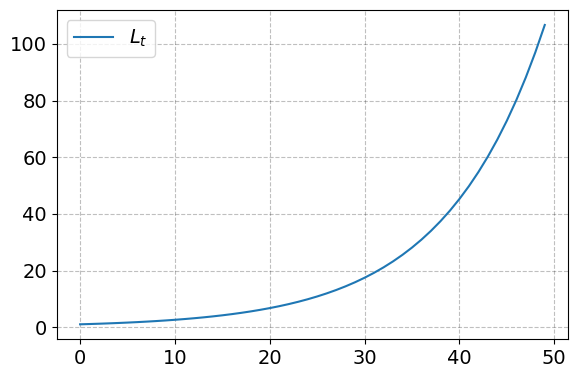

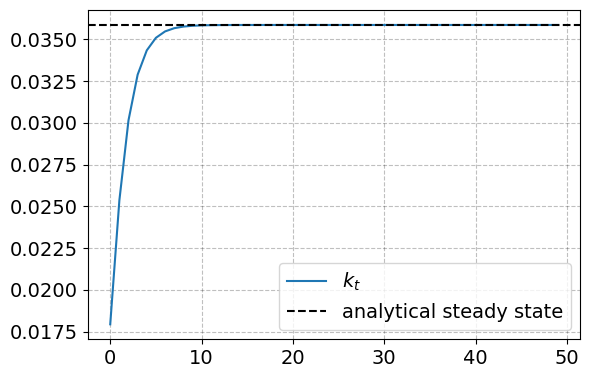

In [6]:
population_plot(par,sim)# plot population growth graph, against steady state level,
capital_accumulation_plot(par,sim) # plot capital accumulation graph, against steady state level, with parameters values as defined before

We see how $L_t$ and $k_{t}$ evolve over 50 periods.

Population, evidently, is growing.

The capital accumulation dynamic confirms the theoretically derived expectations for the long run: **the per-worker capital level converges after less than ten years to the predicted steady-state level**. 

The convergence happens from the bottom up, as we expected since, we imposed a lower than steady-state level of capital as a starting point.

**4) Testing changes in parameters**

We check that the behaviour is still confirmed when slightly changing some baseline parameters and imposing a starting level of capital, this time higher than the steady-state level.

initializing the model:
calling .setup()
calling .allocate()

simulation done in 0.10 secs

optimal saving rate in period 49 = 0.416667


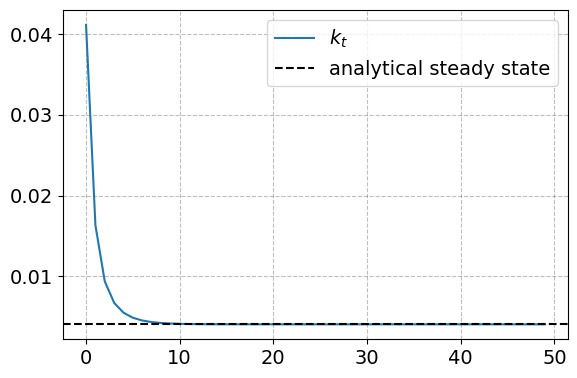

In [7]:
model2 = OLGModelClass() # a new model istance
par2 = model2.par 
sim2 = model2.sim

# Redefining initial capital as respect to steady state
par2.production_function = 'ces'
par2.theta = 0.001
par2.n = 0.5
par2.alpha = 0.6
par2.k_ss = ((1-par2.alpha)/((1+par2.n)*(1+1.0/par2.beta)))**(1/(1-par2.alpha)) # steady-state level of capital for Log utility and Cobb Douglas production
par2.K_lag_ini = 10*par2.k_ss

# simulate the model
model2.simulate()
capital_accumulation_plot(par2,sim2)

The results confirm the good behaviour of the model solver: capital converges closely to the steady-state level, this time from above, since the starting capital endowment was higher than the steady-state level. The change in population growth is not affecting the possibility of convergence but the level at which convergence happen (it both affects the capital dynamic and the theoretical steady-state).

We have to point out, that changing the value of $\sigma$ would result, anyhow, in a slight difference between theoretical steady-state level and actual point level of convergence. This is an expected result: the theoretical formula provided is derived by assuming the special case of Log period utility and cobb-douglas production. When sigma diverges from 1.0 we are no longer in the log period utility special case and the formula for the capital steady-state level is no longer valid.